### Setup

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Load environment variables
load_dotenv()

# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Gather information 

First, let's define the part of the graph that will gather user requirements.

In [2]:
from typing import List

from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [3]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

In [4]:
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages

In [6]:
get_messages_info(["aa", "bb"])


[SystemMessage(content='Your job is to get information from a user about what type of prompt template they want to create.\n\nYou should get the following information from them:\n\n- What the objective of the prompt is\n- What variables will be passed into the prompt template\n- Any constraints for what the output should NOT do\n- Any requirements that the output MUST adhere to\n\nIf you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.\n\nAfter you are able to discern all the information, call the relevant tool.', additional_kwargs={}, response_metadata={}),
 'aa',
 'bb']

In [7]:
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]

In [8]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

In [9]:
def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}


In [10]:
# info_chain({"messages": [HumanMessage(content="I want to create a prompt template that generates a list of 100 random numbers between 1 and 1000. The numbers should be unique and sorted in ascending order.")]})


### Generate Prompt

In [11]:
# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""

In [12]:
# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

In [13]:
# get_prompt_messages([HumanMessage(content="I want to create a prompt template that generates a list of 100 random numbers between 1 and 1000. The numbers should be unique and sorted in ascending order."), AIMessage(content="Here is the prompt template: {{template}}")])


[SystemMessage(content='Based on the following requirements, write a good prompt template:\n\nNone', additional_kwargs={}, response_metadata={})]

In [14]:
def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [15]:
prompt_gen_chain({"messages": [HumanMessage(content="I want to create a prompt template that generates a list of 100 random numbers between 1 and 1000. The numbers should be unique and sorted in ascending order."), AIMessage(content="Here is the prompt template: {{template}}")]})


{'messages': [AIMessage(content='**Prompt Template:**\n\n---\n\n**Title:** [Insert Title Here]\n\n**Objective:** [Clearly state the purpose of the prompt. What do you want to achieve?]\n\n**Context:** [Provide any necessary background information or context that will help in understanding the prompt. This could include relevant details, specific scenarios, or examples.]\n\n**Instructions:** \n1. [List the specific tasks or questions you want the respondent to address.]\n2. [Include any guidelines or constraints that should be followed.]\n3. [Mention the desired format for the response, if applicable (e.g., essay, bullet points, etc.).]\n\n**Additional Notes:** \n- [Include any other relevant information that may assist in crafting a comprehensive response.]\n- [If applicable, specify any resources or references that can be consulted.]\n\n---\n\n**Example Usage:**\n\n**Title:** The Impact of Climate Change on Coastal Cities\n\n**Objective:** To analyze the effects of climate change on u

### Define the state logic

In [16]:
from typing import Literal

from langgraph.graph import END


In [17]:
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [20]:
memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

In [21]:
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [23]:
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END]) # start from info, then by the condition in get_state, go to add_tool_message or info or END
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `get_state` already exists for node `info`

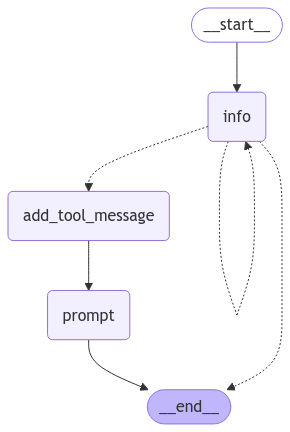

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### Use the graph

In [26]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index] # if user input is not valid, use the cached_human_responses
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): rag ??
================================== Ai Message ==================================

Could you please clarify what you mean by "rag"? Are you looking to create a prompt template related to a specific topic or task? If so, please provide more details about the objective, variables, constraints, and requirements for the prompt.
User (q/Q to quit): math game
================================== Ai Message ==================================

Great! To help you create a prompt template for a math game, I need a bit more information:

1. **What is the objective of the prompt?** (e.g., to generate math problems, to provide hints, etc.)
2. **What variables will be passed into the prompt template?** (e.g., difficulty level, type of math operation, number of questions, etc.)
3. **Are there any constraints for what the output should NOT do?** (e.g., avoid using certain types of problems, no negative numbers, etc.)
4. **What requirements must the output adhere to?** (e.g., mu